# Config

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.optimize import minimize as scipy_optimize_minimize
import inspect
import time

from pprint import pprint as pprint

In [2]:
do_test = True

# Goal functions (models)

## Rosenbrock

In [3]:
def rosenbrock(p, x): 
    if np.isnan(x[0]): # In this case return the minimum
        return np.ones(x.shape)
    else:
        return 42 + sum(p[0]*((x[1:] - x[:-1]**2.0)**2.0) + (p[1] - x[:-1])**2.0)

def rosenbrock_and_grad_f(p,x):
    y_shift = 42 # We should not assume minimum is at 0
    y = y_shift + sum(p[0]*((x[1:] - x[:-1]**2.0)**2.0) + (p[1] - x[:-1])**2.0)
    dy_dp = np.array([sum((x[1:] - x[:-1]**2.0)**2.0), sum(2*(p[1] - x[:-1]))])
    return y, dy_dp

In [4]:

if do_test:
    p_true = np.array([100,1])

    f = lambda x_: rosenbrock(p_true,x_)
    f_and_grad = lambda p_,x_: rosenbrock_and_grad_f(p_,x_)
    noisy_f = lambda x,noise_level: (1 + noise_level*np.random.random()) * f(x)
    
    noise_level = 0.03
    x = np.array([0,0,0])
    print(f"f(x): {f(x)}")
    print(f"f_and_grad(p_true,x): {f_and_grad(p_true,x)}")
    print(f"noisy_f(x, noise_level): {noisy_f(x, noise_level)}\n")

    p1 = np.array([104,0.98])
    dp = 1e-6 * np.array([1,-4])
    xx = np.array([1,6,8,1,0,0,0,2])
    f1,df_dp = f_and_grad(p1,xx)
    df_dp_fin_diff = 0 * df_dp
    for k in range(len(p1)):
        p2 = p1.copy()
        p2[k] += dp[k]
        f2,df_dp2 = f_and_grad(p2,xx)
        df_dp_fin_diff[k] = (f2-f1)/dp[k]

    print(f"f1:             {f1}")
    print(f"df_dp:          {df_dp}")
    print(f"df_dp_fin_diff: {df_dp_fin_diff}")
    
    rel_err = np.linalg.norm(df_dp - df_dp_fin_diff) / np.linalg.norm(df_dp_fin_diff)
    print(f"rel_err:        {rel_err}")
    assert rel_err < 1e-6, "Gradient relative error too big. Please debug."


f(x): 44.0
f_and_grad(p_true,x): (44.0, array([0., 4.]))
noisy_f(x, noise_level): 45.0456024594339

f1:             497551.36279999994
df_dp:          [4783.    -18.28]
df_dp_fin_diff: [4783.00004033  -18.2800286 ]
rel_err:        1.0337300167897221e-08


# Optimization helper functions

In [5]:
def post_process_search_logger(the_log):
    Z = {}
    if the_log is None or len(the_log) == 0: return Z
    for key in the_log[0]:
        Z[key] = [the_log[0][key]]
    for k in range(1,len(the_log)):
        for key in the_log[k]:
            Z[key].append(the_log[k][key])
    return Z

search_logger = []

In [6]:
def minibatch_loss_model_and_grad_wrapper_f(f_model_and_grad_f, f, Xs,Ys,true_Ys, batch_size, p):
    ks = np.random.choice(len(Ys),size=(batch_size,))
    ks = list(range(batch_size))
    loss = 0
    noiseless_loss = 0
    dloss_dp = np.zeros(shape=p.shape)
    for k in ks:
        y, dy_dp = f_model_and_grad_f(p,Xs[k,:])        
        loss += (y-Ys[k])**2
        dloss_dp += 2 * (y-Ys[k]) * dy_dp
        
        noiseless_y = f(p, Xs[k,:])        
        noiseless_loss += (noiseless_y - true_Ys[k])**2
        
    loss = loss / batch_size
    dloss_dp = dloss_dp / batch_size
    loss = np.sqrt(loss)
    if loss == 0:
        dloss_dp = 0
    else:
        dloss_dp = dloss_dp / (2*loss)
    
    noiseless_loss = np.sqrt(noiseless_loss  / batch_size)
    search_logger.append ({'p': p, 'loss': loss, 'noiseless_loss':noiseless_loss})

    return loss, dloss_dp

In [7]:
if do_test:
    batch_size = 32

    N = 7700
    D = 25
    r = 1 # radius of points
    noise_level = 1e-13

    p_true = np.array([100,1])

    f = lambda p_,x_: rosenbrock(p_,x_)

    f = lambda p_,x_: rosenbrock(p_,x_)
    f_and_grad = lambda p_,x_: rosenbrock_and_grad_f(p_,x_)

    true_f = lambda x_: f(p_true,x_)
    x_true_minimum = true_f(np.nan*np.zeros((D,1)))
    f_true_minimum = true_f(x_true_minimum)
    
    noisy_true_f = lambda x_,noise_level_: (1 + noise_level_*np.random.random()) * (true_f(x) - f_true_minimum) + f_true_minimum

    Xs = r * np.random.normal(size=(N,D))
    Ys = np.zeros(shape=(N,1))
    true_Ys = np.zeros(shape=(N,1))
    for n in range(N): 
        true_Ys[n]=true_f(Xs[n,:])
        Ys[n]=noisy_true_f(Xs[n,:],noise_level)
    
    p0 = p_true + np.random.normal(size=p_true.shape)
    loss, dloss_dp = minibatch_loss_model_and_grad_wrapper_f(f_and_grad, f, Xs,Ys, true_Ys, batch_size, p0)
    print(f"loss:     {loss}")
    print(f"dloss_dp: {dloss_dp}\n")

    batch_size = 4
    fff = lambda p_: minibatch_loss_model_and_grad_wrapper_f(f_and_grad, f, Xs,Ys, true_Ys, batch_size, p_)
    p1 = np.array([104,0.97])
    dp = 1e-6 * np.array([1,-4])
    f1,df_dp = fff(p1)
    df_dp_fin_diff = 0 * df_dp
    for k in range(len(p1)):
        p2 = p1.copy()
        p2[k] += dp[k]
        f2,df_dp2 = fff(p2)
        df_dp_fin_diff[k] = (f2-f1)/dp[k]

    print(f"f1:             {f1}")
    print(f"df_dp:          {df_dp}")
    print(f"df_dp_fin_diff: {df_dp_fin_diff}")
    
    rel_err = np.linalg.norm(df_dp - df_dp_fin_diff) / np.linalg.norm(df_dp_fin_diff)
    print(f"rel_err:        {rel_err}")
    assert rel_err < 1e-5, "Gradient relative error too big. Please debug."

loss:     [11910.90219738]
dloss_dp: [118.73695303  71.82550904]

f1:             [9235.22885997]
df_dp:          [88.40404466 40.19517861]
df_dp_fin_diff: [88.40404735 40.19509379]
rel_err:        8.738618365645482e-07


# Optimization algorithms

## Gradient descent

In [8]:
def gradient_descent(loss_and_grad_func, p0, learning_rate=0.01,func_call_budget=10,stopping_func=None):    
    p = p0.copy() # Better safe than sorry
    
    for k in range(func_call_budget):
        loss, loss_grad = loss_and_grad_func(p)
        
        if stopping_func is not None:
            if stopping_func(k_iter, p, loss, loss_grad):
                return p
        
        p = p - learning_rate * loss_grad
    return p



## Adam

Taken from: https://gluon.mxnet.io/chapter06_optimization/adam-scratch.html

In [9]:
# Adam.
# Adapted from: https://gluon.mxnet.io/chapter06_optimization/adam-scratch.html

def Adam_update(p, grad, vs, sqrs, k_iter, alpha=0.1, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8):
    if k_iter == 0:
        vs   = eps_stable * np.ones(len(p))
        sqrs = eps_stable * np.ones(len(p))

    for k in range(len(p)):
        vs[k]   = beta1 * vs[k]    + (1 - beta1) * grad[k]
        sqrs[k] = beta2 * sqrs[k]  + (1 - beta2) * np.square(grad[k])

        v_bias_corr   = vs[k]   / (1 - beta1 ** (k_iter+1)) # Here we want to count from 1
        sqr_bias_corr = sqrs[k] / (1 - beta2 ** (k_iter+1)) # but Python natively counts form 0

        div  = v_bias_corr / (np.sqrt(sqr_bias_corr) + eps_stable)
        p[k] = p[k] - alpha * div
        
    return p,vs,sqrs
        
        
def Adam(loss_and_grad_func, p0, 
         func_call_budget=10, 
         alpha=0.1, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8, 
         stopping_func=None):    
    
    p = p0.copy() # Better safe than sorry
    vs = []
    sqrs = []
    for k_iter in range(func_call_budget):        
        loss, loss_grad = loss_and_grad_func(p)
        
        if stopping_func is not None:
            if stopping_func(k_iter, p, loss, loss_grad):
                return p
            
        new_p, vs, sqrs = Adam_update(p, loss_grad, vs, sqrs, k_iter, alpha,beta1,beta2,eps_stable)
        p = new_p
        
    return p
     

# Compare optimization algorithms

## Config

In [10]:
N = 7700
D = 2
r = 1 # radius of points
total_budget = 100_000

batch_size = 20

noise_level = 1e-3

p_true = np.array([100,1])

f = lambda p_,x_: rosenbrock(p_,x_)
f_and_grad = lambda p_,x_: rosenbrock_and_grad_f(p_,x_)


## Prep data

In [11]:
true_f = lambda x_: f(p_true,x_)
x_true_minimum = true_f(np.nan*np.zeros((D,1)))
f_true_minimum = true_f(x_true_minimum)
noisy_f = lambda x,noise_level_: (1 + noise_level_*np.random.random()) * (true_f(x) - f_true_minimum) + f_true_minimum

Xs = r * np.random.normal(size=(N,D))
Ys = np.zeros(shape=(N,1))
true_Ys = np.zeros(shape=(N,1))
for n in range(N): 
    true_Ys[n] = true_f(Xs[n,:])
    Ys[n]=noisy_f(Xs[n,:],noise_level)
    
    
p0 = p_true + 5 * np.random.normal(size=p_true.shape)

loss_and_grad_func = lambda p_: minibatch_loss_model_and_grad_wrapper_f(
    f_and_grad, f, Xs,Ys, true_Ys, batch_size, p_)
tmp_loss, tmp_grad = loss_and_grad_func(p0) # Just testing the call works

print(f"p_true:  {p_true}")
print(f"p0:      {p0}")


loss_history = {}

p_true:  [100   1]
p0:      [104.44467957  -0.19125302]


## SGD (Stochastic) GD

In [12]:
alpha_range = range(-4,0)

print(f"SGD(alpha=10^{alpha_range})\n")
print(f"    p_true:  {p_true}")
print(f"    p0:      {p0}")

for alpha_log10 in alpha_range:
    alpha = 10**alpha_log10
    search_method_name = f"SGD(alpha=10^{alpha_log10})"
    print(f"    {search_method_name} ... ", flush=True, end='')

    t0=time.time()
    search_logger = []
    p_last = gradient_descent(loss_and_grad_func, p0, 
                              learning_rate=alpha,
                              func_call_budget=total_budget//batch_size,
                              stopping_func=None)
    elapsed_t = time.time()-t0
    print(f"done in {elapsed_t:.3f}s")

    search_log = post_process_search_logger(search_logger)
    loss_history[search_method_name] = search_log

    print(f"        p_last:  {search_log['p'][-1]} with loss {(search_log['loss'][-1][0]):.3g}")

SGD(alpha=10^range(-4, 0))

    p_true:  [100   1]
    p0:      [104.44467957  -0.19125302]
    SGD(alpha=10^-4) ... done in 5.595s
        p_last:  [100.06605117   0.54229544] with loss 0.819
    SGD(alpha=10^-3) ... done in 5.512s
        p_last:  [100.05567615   0.98692182] with loss 1.08
    SGD(alpha=10^-2) ... done in 6.215s
        p_last:  [100.30942836   0.98890372] with loss 10.7
    SGD(alpha=10^-1) ... done in 5.911s
        p_last:  [98.15627177  1.46754282] with loss 89.9


## L-BFGS-B (from scipy)

In [13]:
search_method_name = 'scipy(L-BFGS-B)'
print(f"{search_method_name} ... ", flush=True, end='')

t0=time.time()
search_logger = []
opt_res = scipy_optimize_minimize(loss_and_grad_func, p0, method='L-BFGS-B', 
                                  jac=True, tol=1e-12, 
                                  options={'maxiter':total_budget//batch_size, 'disp':True})
print(f"done in {(time.time()-t0):.3f}s\n")

search_log = post_process_search_logger(search_logger)
loss_history[search_method_name] = search_log

print(f"p_true:  {p_true}")
print(f"p0:      {p0}")
print(f"p_last:  {search_log['p'][-1]} with loss {(search_log['loss'][-1][0]):.3g}")

scipy(L-BFGS-B) ... done in 0.094s

p_true:  [100   1]
p0:      [104.44467957  -0.19125302]
p_last:  [100.07867839   0.98624661] with loss 0.153


## Adam

In [14]:
alpha_range = range(-4,1)

print(f"Adam(alpha=10^{alpha_range})\n")
print(f"    p_true:  {p_true}")
print(f"    p0:      {p0}")

for alpha_log10 in alpha_range:
    alpha = 10**alpha_log10
    search_method_name = f"Adam(alpha=10^{alpha_log10})"
    print(f"    {search_method_name} ... ", flush=True, end='')

    t0=time.time()
    search_logger = []
    p_last = Adam(loss_and_grad_func, p0, 
                  func_call_budget=total_budget//batch_size,
                  alpha=alpha)
    elapsed_t = time.time()-t0
    print(f"done in {elapsed_t:.3f}s")

    search_log = post_process_search_logger(search_logger)
    loss_history[search_method_name] = search_log

    print(f"        p_last:  {search_log['p'][-1]} with loss {(search_log['loss'][-1][0]):.3g}")      

Adam(alpha=10^range(-4, 1))

    p_true:  [100   1]
    p0:      [104.44467957  -0.19125302]
    Adam(alpha=10^-4) ... done in 6.441s
        p_last:  [103.94467836   0.29766664] with loss 181
    Adam(alpha=10^-3) ... done in 5.628s
        p_last:  [100.07867839   0.98624683] with loss 0.153
    Adam(alpha=10^-2) ... done in 5.383s
        p_last:  [100.07884453   0.98608856] with loss 0.153
    Adam(alpha=10^-1) ... done in 5.563s
        p_last:  [100.08131085   0.98365336] with loss 0.198
    Adam(alpha=10^0) ... done in 5.542s
        p_last:  [100.13786941   0.96440314] with loss 4.7


# Plot results

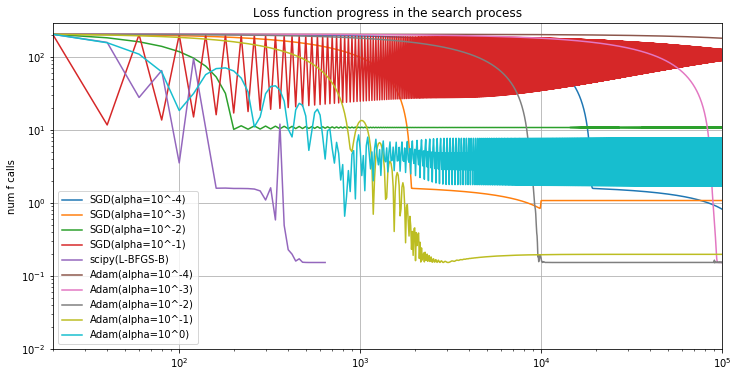

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
for key in loss_history:
    label = key
    losses = loss_history[key]['loss']
    ax.loglog(np.array(list(range(1,1+len(losses))))*batch_size,losses, label=label)    
x1,x2,y1,y2 = plt.axis()
ax.set_xlim([batch_size,total_budget])
ax.set_ylim([1e-2,y2])
plt.ylabel('loss')
plt.ylabel('num f calls')
plt.grid(True)
plt.legend(loc='lower left')
plt.title ('Loss function progress in the search process')
plt.show()

if False:
    fig, ax = plt.subplots(figsize=(12,6))
    for key in loss_history:
        label = key
        noiseless_loss = loss_history[key]['noiseless_loss']
        ax.loglog(np.array(list(range(1,1+len(noiseless_loss))))*batch_size,noiseless_loss, label=label)    
    x1,x2,y1,y2 = plt.axis()
    ax.set_xlim([batch_size,total_budget])
    ax.set_ylim([1e-8,y2])
    plt.ylabel('Noiseless loss')
    plt.ylabel('num f calls')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.title ('Noiseless loss function progress in the search process')
    plt.show()